In [20]:
import gc
import psutil
import time
import numpy as np
import matplotlib.pyplot as plt
from rur import uri, uhmi, drawer, painter
import copy

from tree_utool import *
from tree_root import Treebase

# Select target

In [21]:
# modes = [\
#     'y04466','y05420','y05427','y07206',\
#     'y10002','y17891','y24954','y29172',\
#     'y29176','y35663','y36413','y36415',\
#     'y39990','y49096'\
#         ]
mode = 'y07206' # 
# mode = 'nh' # 
repo, rurmode = mode2repo(mode)

galaxy=True
nout = load_nout(mode, galaxy=galaxy)

prefix = f"[{mode}]"
print(f"{prefix} {nout[-1]} ~ {nout[0]}")

iout = np.max(nout)
uri.timer.verbose = 0
snap_now = uri.RamsesSnapshot(repo, iout, path_in_repo='snapshots', mode=rurmode )
gals_now = uhmi.HaloMaker.load(snap_now, galaxy=True)
# snap_now.clear()

# 69, 93, 105, 124, 133, 138, 166, 172, 188
target = gals_now[69-1]
# gals_now = gals_now[gals_now['m']>1e10]
# target = gals_now[np.random.randint(0, len(gals_now)-1, 1)][0]
printgal(target, mode=mode, nout=nout)
# fname = f"Branch_{mode}_{target['id']:05d}.pickle"
# if not os.path.isfile(f"./data/{fname}"):
#     raise ValueError(f"cannot found {fname}")

[y07206] 10 ~ 99
[GalaxyMaker: y07206] ID=69, iout(istep)=99(90), logM=9.87


'[GalaxyMaker: y07206] ID=69, iout(istep)=99(90), logM=9.87'

# Load TreeMaker

## Functions

In [22]:
def tm_return_fat(target, usefat2=False):
    fat = target['fat1']
    if fat > 0:
        return fat
    elif usefat2:
        fat = target['fat2']
        if fat > 0:
            return fat
        else:
            return None

def tm_return_branch(target, tm=None, usefat2=False, galaxy=True, mode='hagn'):
    minstep, maxstep = np.min(tm['timestep']), np.max(tm['timestep'])
    nout = load_nout(mode, galaxy=galaxy)
    nstep = load_nstep(mode, galaxy=galaxy, nout=nout)
    if 'nparts' in target.dtype.names:
        iout, istep = ioutistep(target, galaxy=galaxy, mode=mode, nout=load_nout(mode, galaxy=galaxy))
        offset = maxstep - np.max(nstep)
        target = loadgals(istep+offset, target['id'], tm=tm)
    # printgal(target, mode=mode, nout=load_nout(mode, galaxy=galaxy))
    istep = target['timestep']
    leng = istep - minstep
    fat = tm_return_fat(target, usefat2=usefat2)
    if fat is None:
        print(f"no single father")
        return np.atleast_1d(target)
    branch = target
    for i in range(leng):
        igal = loadgals(istep-1-i, fat, tm=tm)
        branch = np.hstack((branch, igal))
        fat = tm_return_fat(igal, usefat2=usefat2)
        if fat is None:
            if istep-i-1 > 1:
                print(f"broken at step={istep-i-1}")
            return branch
    return branch

def loadgals(istep, galid, tm=None):
    ind = (tm['timestep']==istep)&(tm['id']==galid)
    return tm[ind][0]

In [23]:
tm = uhmi.TreeMaker.load(snap_now,galaxy=True)
TMbranch = tm_return_branch(target, tm=tm, galaxy=galaxy, mode=mode)

Reading /storage3/Clusters/07206/GalaxyMaker/gal/tree.dat... 
Took 0.216s
Building table for 19 nodes...  Number of steps found:         168
 Total number of halos:       78040
Progress: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> - Done!
Took 0.024s


# Load Ptree

## Functions

In [24]:
def pt_return_branch(target, pt=None, leng=None):
    instpt = pt[pt['timestep']==target['timestep']]
    # ind = (pt['hmid']==target['id'])&(pt['timestep']==target['timestep'])
    igal = instpt[instpt['hmid']==target['id']][0]
    # igal = pt[ind][0]
    branch = igal
    i = 1
    while igal['fat']>0:
        igal = pt[pt['id']==igal['fat']][0]
        branch = np.hstack((branch, igal))
        i +=1
        if leng is not None:
            if i>=leng:
                break
    return branch

In [25]:
pt = pklload(f"{repo}/ptree/ptree_stable.pkl")
PTbranch = pt_return_branch(target, pt=pt, leng=100)

# Load YoungTree

## Functions

In [26]:
readme,root, t_elapsed, YTbranch, scores = pklload(f"./data/Branch_{mode}_{target['id']:05d}.pickle")
YTbranch = np.hstack([val for val in YTbranch.values()])

# Compare

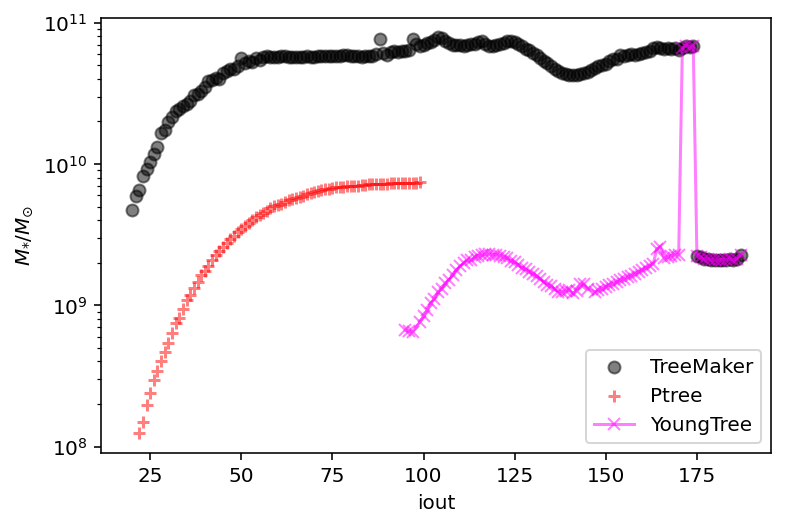

In [29]:
fig, ax = plt.subplots(figsize=(6,4))


ax.scatter(TMbranch['timestep']-168+187, TMbranch['m'], color='black', label='TreeMaker', marker='o', alpha=0.5)
ax.scatter(PTbranch['timestep'], PTbranch['m'], color='red', label='Ptree', marker='+', alpha=0.5)
ax.plot(YTbranch['timestep'], YTbranch['m'], color='magenta', label='YoungTree', marker='x', alpha=0.5)

ax.set_yscale("log")
ax.legend()

ax.set_ylabel("$M_{*} / M_{\odot}$")
ax.set_xlabel("iout")
fig.set_facecolor("white")
fig.set_dpi(144)

In [28]:
printgal(target, mode=mode)

[GalaxyMaker: y07206] ID=69, iout(istep)=99(90), logM=9.87


'[GalaxyMaker: y07206] ID=69, iout(istep)=99(90), logM=9.87'

225, 10, 33

# Draw

In [42]:
center = target
# center = YTbranch[52]
# center

In [45]:
offset = np.max(nout)-np.max(TMbranch['timestep'])
uri.timer.verbose=0
snap = uri.RamsesSnapshot(repo, center['timestep'], mode='yzics')
gm, gmpid = uhmi.HaloMaker.load(snap, galaxy=galaxy, load_parts=True)
cumparts = np.insert(np.cumsum(gm["nparts"]), 0, 0)
gmpid = [gmpid[ cumparts[i]:cumparts[i+1] ] for i in range(len(gm))]
gmpid = copy.deepcopy(gmpid)
inipart = gmpid[center['id']-1]
for iout in nout[nout<=center['timestep']]:
    snap = uri.RamsesSnapshot(repo, iout, mode='yzics')
    snap.set_box_halo(center, radius=30)
    snap.box[0] -= center['rvir']*20
    # snap.box[1] -= center['rvir']*10
    snap.box[2][0] -= 0.01
    snap.box[2][1] += 0.01
    x1, x2 = snap.box[0][0], snap.box[0][1]
    y1, y2 = snap.box[1][0], snap.box[1][1]
    snap.get_part()
    # snap.get_cell()

    fig, axes = plt.subplots(ncols=2,figsize=(12,6))
    fig.set_dpi(144)
    ax = axes[0]
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    
    ax.scatter(snap.part['star']['x'], snap.part['star']['y'],s=0.1,alpha=0.1)
    isin = large_isin(np.abs(snap.part['star']['id']), inipart)
    ax.scatter(snap.part['star']['x'][isin], snap.part['star']['y'][isin],s=0.1,alpha=0.3)
    
    if iout-offset in TMbranch['timestep']:
        galtm = TMbranch[TMbranch['timestep'] == iout-offset][0]
        cir = plt.Circle((galtm['x'], galtm['y']), galtm['r'], edgecolor='black', facecolor='none', label=f'TreeMaker (ID={galtm["id"]}, logM={np.log10(galtm["m"]):.2f})')
        ax.add_artist(cir)
    if iout in PTbranch['timestep']:
        galpt = PTbranch[PTbranch['timestep'] == iout][0]
        cir = plt.Circle((galpt['x'], galpt['y']), galpt['r'], edgecolor='red', facecolor='none', label=f'PTree (ID={galpt["hmid"]}, logM={np.log10(galpt["m"]):.2f})')
        ax.add_artist(cir)
    if iout in YTbranch['timestep']:
        galyt = YTbranch[YTbranch['timestep'] == iout][0]
        cir = plt.Circle((galyt['x'], galyt['y']), galyt['r'], edgecolor='magenta', facecolor='none', label=f'YoungTree (ID={galyt["id"]}, logM={np.log10(galyt["m"]):.2f})')
        ax.add_artist(cir)
    ax.legend(loc='upper right')
    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)

    ax = axes[1]
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    partimg = painter.partmap(snap.part['star'], shape=240)
    # cellimg = painter.gasmap(snap.cell, shape=240)
    # combimg = painter.composite_image([partimg, cellimg], cmaps=[plt.cm.gray, plt.cm.copper], qscales=[3,3],mode='multiply')
    # ax.imshow(combimg, origin='lower')
    ax.imshow(partimg, origin='lower', cmap=plt.cm.magma, extent=[x1,x2,y1,y2])
    ax.text(0.05, 0.95, f"iout={snap.iout}\nz={snap.params['z']:.2f} ({snap.params['age']:.2f} Gyr)", ha='left', va='top', transform=ax.transAxes, color='white', fontsize=16)

    snap.clear()
    plt.subplots_adjust(wspace=0)
    plt.savefig(f"{iout:03d}.png", dpi=144, bbox_inches='tight',pad_inches = 0)
    plt.close()
    
    
    
    

Computing particle map of 2324834 particles... 
Done (0.129s).
Computing particle map of 2331711 particles... 
Done (0.149s).
Computing particle map of 2341988 particles... 
Done (0.138s).
Computing particle map of 2374174 particles... 
Done (0.128s).
Computing particle map of 2376799 particles... 
Done (0.142s).
Computing particle map of 2387503 particles... 
Done (0.133s).
Computing particle map of 2392047 particles... 
Done (0.142s).
Computing particle map of 2407750 particles... 
Done (0.130s).
Computing particle map of 2411214 particles... 
Done (0.142s).
Computing particle map of 2422092 particles... 
Done (0.135s).
Computing particle map of 2422745 particles... 
Done (0.145s).
Computing particle map of 2398537 particles... 
Done (0.130s).
Computing particle map of 2393934 particles... 
Done (0.137s).
Computing particle map of 2368839 particles... 
Done (0.137s).
Computing particle map of 2338565 particles... 
Done (0.139s).
Computing particle map of 2333312 particles... 
Done (0

KeyboardInterrupt: 